# A<sub>gent-based</sub> L<sub>and</sub> MA<sub>rket</sub> (ALMA)

The Agent-based Land MArket (ALMA) model is a "bilateral agent-based land market model, which moves beyond previous work by explicitly modeling behavioral drivers of land-market transactions on both the buyer and seller sides; formation of bid prices (of buyers) and ask prices (of sellers); and the relative division of the gains from trade from the market transactions" ([Filatova, Parker, and van der Veen](http://jasss.soc.surrey.ac.uk/12/1/3.html)). The model aims to understand the micro-economic decision-making that results in the emergent behavior described as the "rent gradient."

![Rent Gradient](img/BidRentCurve.png)

[Image Source: Wikipedia](https://en.wikipedia.org/wiki/Bid_rent_theory)

[Bid-rent theory](https://en.wikipedia.org/wiki/Bid_rent_theory) describes a geographical economy theory that was developed by William Alsono in his book *Location and Land Use.* It asserts that the demand for and price of land in and around cities is a function of distance from the Central Business District (CBD) of the urban center. The relationship between distance from the CBD and land price/rent prices is referred to as the "rent gradient."

In this notebook we will work with a slightly expanded version of the ALMA model that introduces more stochasticity and heterogeniety, to understand how the rent gradient changes under various settings.

* [A conceptual design for a bilateral agent-based land market with heterogeneous economic agents](https://doi.org/10.1016/j.compenvurbsys.2008.09.012)
* [Agent-Based Urban Land Markets: Agent's Pricing Behavior, Land Prices and Urban Land Use Change](http://jasss.soc.surrey.ac.uk/12/1/3.html)
* [Location and Land Use](https://www.hup.harvard.edu/catalog.php?isbn=9780674730854)


![Example of the ALMA model gif](img/Example.gif)

To run the notebook, please uncomment and run the cell below and then restart the kernel using Kernel -> Restart Kernel. You should then be able to run the notebook as normal.

In [1]:
# !pip install imageio

In [2]:
import argparse, csv, heapq, json, math, os, random, shutil
from copy import copy, deepcopy
import numpy as np
from numpy import linalg as LA
from operator import attrgetter
import pandas as pd
from time import localtime, strftime
from tqdm import tqdm

import Viz as viz

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import Image, display

""" Making sure you output folder """
if not os.path.exists("./outputs"):
    os.mkdir("./outputs")

## Cells

The ALMA model represents land as uniform-size cells. The cells have two main features that derive their worth:

* `Amenity` - some uniformly distributed [amenity](https://en.wikipedia.org/wiki/Amenity).
* `Proximity` - the relative closeness to the central business district. For cell $i$ with distance from the CBD $D_{i}$, we calculate proximity as:

$$ \bar{P}_{i}=D_{max}+1-D_{i}$$

$$ P=\bar{P}_{i}/\bar{P}_{max}$$

This gives us a relative measure $\bar{P}\in[0,1]$ where low values represent far from the CBD and high values represent low distance from the CBD.

The `transact` function allows a sell to transfer owners. Under the ALMA framework, the top bid is chosen and the transaction price is the average between the ask and the bid.

In [3]:
class Cell:

    def __init__(self, args):
        self.amenity = args["amenity"] # vector of floats
        self.cbd = args["cbd"] # vector of floats
        self.id = args["id"] # int
        self.location = args["location"] # tuple
        self.market_price = 0.0 # float
        self.owner = args["owner"] # int
        self.wta = args["wta"]
        self.p_ask = self.wta
        # optional args
        if "on_market" in args:
            self.on_market = args["on_market"]
        else:
            self.on_market = False
        # data structures
        self.bids = [] # stack of bids
        # calculate distance and proximity
        self.distance = float("inf")
        self.proximity = float("inf")

    def __repr__(self):
        return "Cell {} at {} owned by {}\n Amenity: {}\n CBD: {}\n Prox: {}".format(self.id,self.location,self.owner,self.amenity, self.cbd, self.proximity)

    def __str__(self):
        return self.__repr__()

    def get_location(self):
        return deepcopy(self.location)

    def transact(self, bid, owner):
        self.market_price = (self.p_ask+bid["bid"])/2.0
        self.on_market = False
        self.owner = bid["bidder"]

    def update_market_status(self, on_market, epsilon):
        self.on_market = on_market
        if on_market:
            self.p_ask = self.wta*(1+epsilon)

<a id="agents" >
</a>

## Agents

Agents in the model can either be buyers or sellers. 

### Buyers

Buyers want to find the best cell for them and buy it using their budget. They have a set of preferences It is assumed for this model that the housing budget is separable. To determine the best sell for them, they calculate the *utility* (usefullness) of each cell using the following formula:

$$A^{\alpha}\times P^{\beta}$$

where A is the cell's level of amenity, P is the proximity, and $\alpha,\beta$ are the buyer's amenity and proximity preferences respectively. Once a cell is selected, the amount that can be spent on the land ($Y$) is calculated by subtracting transportation costs ($T(D)=cost\times D$) from the housing budget ($Y_{housing}$). This is then used to calculate how much the buyer is willing to pay (WTP) using:

$$WTP=\frac{Y\cdot U^{2}}{b^{2}+U^{2}}$$

Where $b$ is a parameter called "affordability." Lastly, the WTP value is used to calculate the buyer's bid which encorporates the market's state (the number of buyers (NB) vs the level of sellers (NS)). The formula becomes:

$$P_{bid}=WTP\cdot (1+\epsilon), \text{ where } \epsilon=\frac{NB-NS}{NB+NS}$$

### Sellers

Sellers each own a single piece of land and are willing to accept some value $WTA$ (usually set to 250). Sellers also use the market state (as measured by $\epsilon$) to determine their asking price:

$$P_{ask}=WTA\cdot(1+\epsilon)$$

In [4]:
class Person:

    def __init__(self, args):
        self.affordability = args["affordability"]
        self.budget = args["budget"]
        self.buying = args["buying"]
        self.distance_cost = args["distance_cost"]
        self.id = args["id"]
        self.selling = args["selling"]
        self.cell = None
        self.utility = -1 # record utility of cell if purchases one
        # preferences
        self.amenity_preference = args["amenity"] # float
        self.proximity_preference = args["proximity"] # float
        # data structures
        self.bids = [] # list of outstanding bids

    def calculate_utility(self, cell):
        return np.power(cell.amenity, self.amenity_preference)*np.power(cell.proximity, self.proximity_preference)

    def evaluate_cells(self, cells):
        best_cell, best_utility = None, 0
        for cell in cells:
            utility = self.calculate_utility(cell)
            if utility > best_utility:
                best_cell, best_utility = cell, utility
        if best_cell != None:
            self.utility = best_utility
            _u_squared=math.pow(best_utility,2)
            _y=self.budget-(self.distance_cost*best_cell.distance)
            _wtp = (_y*_u_squared)/(math.pow(self.affordability,2)+_u_squared)
            return best_cell.id, _wtp
        else:
            self.utility = -1
            return -1, -1

<a id="sim">
</a>

## Simulation

The simulation is below. The basic steps of the simulation are:

* `init_agents` - setting up the Buyers and Sellers
* `init_cells` - setting up the Cells
* `run_simulation` - the loop that allows agents to evaluate cells and allows transactions to happen

In [5]:
class Simulation:

    def __init__(self, args):
        self.height = args["simulation"]["height"]
        self.output_directory = args["simulation"]["output_directory"]
        self.sim_length = args["simulation"]["sim_length"]
        self.width = args["simulation"]["width"]
        # UI arguments:
        self.gif = args["ui"]["generate_gif"]
        self.show_ui = args["ui"]["show"]
        self.ui_components = args["ui"]["components"]
        self.ui_style = args["ui"]["style"]
        # calculated fields
        self.num_cells = self.height * self.width
        self.time = np.arange(0,self.sim_length)
        self.time_step = 0
        DATE = '{}'.format(strftime('%Y-%m-%d_%H:%M:%S', localtime()))
        self.output_directory = os.path.join("./outputs/", "{}ALMA-{}-({}cells)".format(self.output_directory,DATE, self.num_cells))
        if not os.path.exists(self.output_directory):
            os.makedirs(self.output_directory)
        # create csv writers
        self.csv_output_files = {  "agents" : None, "cells" : None }
        for key in self.csv_output_files.keys():
            self.csv_output_files[key] = open(os.path.join(self.output_directory, "{}.csv".format(key)), "w+")
        self.csv_output_writer = {}
        for key in self.csv_output_files.keys():
            self.csv_output_writer[key] = csv.writer(self.csv_output_files[key])
        # setup agents
        self.init_agents(args["agents"])
        self.init_cells(args["cells"])
        self.epsilon_over_time = []
        self.num_buyers, self.num_sellers = [], []
        self.num_neither, self.num_on_market = [], []
        self.run_simulation()
        viz.get_ui(self, show=self.show_ui)
        if self.gif:
            viz.generate_gif(self)
        self.write_out_cells()
        self.write_out_agents()
        for key in self.csv_output_files.keys():
            self.csv_output_files[key].close()

    def calculate_proximity(self):
        cbd = [cell for cell in self.cells if cell.cbd == 1].pop()
        self.proximity = []
        max_dist = 0
        for cell in self.cells:
            cell.distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(cbd.get_location(), cell.get_location())]))
            if cell.distance > max_dist:
                max_dist = cell.distance
        for cell in self.cells:
            cell.proximity = (max_dist - cell.distance)/max_dist
            self.proximity.append(cell.proximity)

    def get_agents(self):
        return deepcopy(self.agents)

    def get_amenities(self):
        amenities = []
        for i in range(self.num_cells):
            if (i%self.width == 0):
                amenities.append([])
            amenities[int(i/self.width)].append(self.cells[int(self.width*int(i/self.width) + i%self.width)].amenity)
        return deepcopy(amenities)

    def get_market_prices(self):
        market_prices = []
        for i in range(self.num_cells):
            if (i%self.width == 0):
                market_prices.append([])
            market_prices[int(i/self.width)].append(self.cells[int(self.width*int(i/self.width) + i%self.width)].market_price)
        return deepcopy(market_prices)

    def get_proximities(self):
        proximities = []
        for i in range(self.num_cells):
            if (i%self.width == 0):
                proximities.append([])
            proximities[int(i/self.width)].append(self.cells[int(self.width*int(i/self.width) + i%self.width)].proximity)
        return deepcopy(proximities)

    def init_agents(self, args):
        self.buyer_level = args["buyer_level"]
        _num_buyers = int(self.num_cells*self.buyer_level)
        _num_sellers = int(self.num_cells)
        self.num_agents = _num_buyers + _num_sellers
        self.agents = []
        for i in range(self.num_agents):
            alpha = random.uniform(0,args["alpha_max"])
            _budget = int(random.uniform(args["budget_parameters"][0], args["budget_parameters"][1]))
            buying = True if i < _num_buyers else False
            self.agents.append(Person({ "affordability" : copy(args["affordability"]),
                                        "amenity": alpha,
                                        "budget" : _budget,
                                        "buying" : buying,
                                        "distance_cost" : copy(args["distance_cost"]),
                                        "id" : copy(i),
                                        "proximity" : random.uniform(0,(1-alpha)),
                                        "selling" : not buying
                                        }))

    def init_cells(self, args):
        self.cells = []
        for i in range(self.num_cells):
            cell_args = {
                "amenity" : random.uniform(0,1),
                "cbd" : 0,
                "id" : i,
                "location": (i//self.width,i%self.width),
                "owner" : 0,
                "wta" : float(args["wta"])
            }
            self.cells.append(Cell(deepcopy(cell_args)))
        cbd = int(self.width*int(self.height/2)+(self.width/2))
        self.cells[cbd].cbd = 1
        self.calculate_proximity()
        _buyers = [ agent.id for agent in self.agents if agent.buying ]
        _sellers = [ agent.id for agent in self.agents if agent.selling ]
        for i in range(len(self.cells)):
            choice = random.choice(_sellers)
            self.cells[i].owner = choice
            self.agents[choice].cell = i
            _sellers.remove(choice)
        self.epsilon=(len(_buyers)-len(_sellers))/(len(_buyers)+len(_sellers))

    def run_simulation(self):
        viz.plot_cells(self,"Amenity", self.ui_components)
        viz.plot_cells(self,"Proximity", self.ui_components)
        transaction_counts = []
        for time_step in tqdm(range(self.sim_length), position = 0, desc="Simulation:"):
            self.time_step = time_step
            # reset bids:
            for i in range(len(self.cells)):
                self.cells[i].bids = []
            # sellers form ask
            for i in range(len(self.agents)):
                if self.agents[i].selling:
                    self.cells[self.agents[i].cell].update_market_status(True, self.epsilon)
            # get statistics and setup for time step
            self.buyers = [ agent.id for agent in self.agents if agent.buying ]
            self.num_buyers.append(len(self.buyers))
            self.sellers = [ agent.id for agent in self.agents if agent.selling ]
            self.num_sellers.append(len(self.sellers))
            self.num_neither.append(self.num_agents-(self.num_buyers[time_step]+self.num_sellers[time_step]))
            self.num_on_market.append(len([cell for cell in self.cells if cell.on_market ]))
            self.epsilon=(self.num_buyers[time_step]-self.num_sellers[time_step])/(self.num_buyers[time_step]+self.num_sellers[time_step])
            self.epsilon_over_time.append(self.epsilon)
            # buyers form bid
            for i in self.buyers:
                _cell, _wtp = self.agents[i].evaluate_cells(deepcopy([ cell for cell in self.cells if (cell.on_market and cell.owner != i) ]))
                if _cell != -1:
                    self.cells[_cell].bids.append({ "bid" : _wtp*(1+self.epsilon), "bidder" : i, "cell" : _cell })
            # negotiate
            transactions = 0
            for i in self.sellers:
                cell = self.agents[i].cell
                if len(self.cells[cell].bids) > 0:
                    _max_bid = max(self.cells[cell].bids, key=lambda x: x["bid"])
                    if _max_bid["bid"] > self.cells[cell].p_ask:
                        self.cells[cell].transact(_max_bid, self.agents[self.cells[cell].owner])
                        self.agents[i].cell, self.agents[i].selling = None, False
                        self.agents[_max_bid["bidder"]].cell, self.agents[_max_bid["bidder"]].buying = cell, False
                        transactions+=1
            for i in range(len(self.agents)):
                if self.agents[i].buying:
                    self.agents[i].utility = -1 # reset utility if they haven't bought a cell
            transaction_counts.append(transactions)
            if self.gif:
                viz.get_ui(self,components=self.ui_components, show=False, save=True)

    def write_out_agents(self):
        print("writing out agents...")
        header = [ "Agent_ID", "Affordability", "Budget", "Distance_Cost", "Buying", "Selling", "Amenity_Preference", "Proximity_Preference", "Utility" ]
        self.csv_output_writer["agents"].writerow(header)
        for agent in self.agents:
            row = [ agent.id, agent.affordability, agent.budget, agent.distance_cost, agent.buying, agent.selling, agent.amenity_preference, agent.proximity_preference, agent.utility ]
            self.csv_output_writer["agents"].writerow(row)

    def write_out_cells(self):
        print("writing out cells...")
        header = [ "Cell_ID", "Location_X", "Location_Y", "Owner", "Market_Price", "On_Market", "Amenity", "Proximity" ]
        self.csv_output_writer["cells"].writerow(header)
        for cell in self.cells:
            row = [cell.id, cell.location[0], cell.location[1], cell.owner, cell.market_price, cell.on_market, cell.amenity, cell.proximity ]
            self.csv_output_writer["cells"].writerow(row)

## Parameters

Below you will find a variety of widgets that allow you to set the parameters for our model. Here is a brief explanation of the parameters:

* `Affordability` - parameter that controls the steepness of the WTP function's tendency to $Y$ as $U\to 1$. Filatova and Parker describe it as "as a proxy of the affordability of all other goods to reflect their relative influence on the WTP for housing" and describe the demand curve in depth [in Appendix A of their paper](http://jasss.soc.surrey.ac.uk/12/1/3.html#appendixa)
* `Alpha Max` - the maximum value that an agent can have for the environmental preference ($\alpha$). Because $\alpha+\beta=1$ and both $\alpha,\beta$ are drawn from uniform distributions, we also have that $\bar{\alpha}=\alpha_{max}/2$ and $\bar{\beta}=1-\bar{\alpha}$.
* `Budget Min` - the minimum value for the uniform budget distribution. Must be less than or equal to `Budget Max`.
* `Budget Max` - the maximum value for the uniform budget distribution. Must be greater than or equal to `Budget Min`.
* `City Height` - height in cells of the simulation
* `City Width` - width in cells of the simulation
* `Sim Length` - length in time steps of the simulation

**NOTES:**

* The UI is optimized for `City Height`$\approx$`City Width` so the output may look very odd if this is not true.


In [6]:
affordability_slider = widgets.FloatSlider(value=0.7, min = .01, max=1, description="Affordability")
alpha_max_slider = widgets.FloatSlider(value = 0.2, min = 0, max = 1, description="Alpha Max:")
budget_low_slider = widgets.FloatSlider(value=800,min=400,max=1200,description="Budget Min")
budget_high_slider = widgets.FloatSlider(value=800,min=800,max=1600,description="Budget Max")
buyer_level_slider = widgets.FloatSlider(value = 1, min = 0.1, max = 4, description = "Buyer Level: ")
city_height_slider = widgets.IntSlider(value = 13, min = 1, max = 50, description = "City Height: ")
city_width_slider = widgets.IntSlider(value = 13, min = 1, max = 50, description = "City Width: ")
sim_len_slider = widgets.IntSlider(value=50, min=20, max=100, description="Sim Length:")
display(affordability_slider,alpha_max_slider,budget_low_slider,budget_high_slider,buyer_level_slider, city_height_slider, city_width_slider,sim_len_slider)

FloatSlider(value=0.7, description='Affordability', max=1.0, min=0.01)

FloatSlider(value=0.2, description='Alpha Max:', max=1.0)

FloatSlider(value=800.0, description='Budget Min', max=1200.0, min=400.0)

FloatSlider(value=800.0, description='Budget Max', max=1600.0, min=800.0)

FloatSlider(value=1.0, description='Buyer Level: ', max=4.0, min=0.1)

IntSlider(value=13, description='City Height: ', max=50, min=1)

IntSlider(value=13, description='City Width: ', max=50, min=1)

IntSlider(value=50, description='Sim Length:', min=20)

## User Interface

You can also customize the UI that is shown for the simulation! The configuration is in `args['ui']['components']`.

The first element of the list is the characteristic you'd like to color the cells for. You can use the following:
* "Market Price" for market prices
* "Proximity" for proximity

For the rest of the list, the following graphs/charts are supported:
* "Histo: Agent Budget" for a histogram of agent's budgets
* "Histo: Market Price" for a histogram of market prices
* "Line: Epsilon" for a line graph of epsilon over time
* "Scatter: Amenity-Market Price" for a scatterplot of Market Prices vs. Amenity
* "Scatter: Proximity-Market Price" for a scatterplot of Market Price vs. Proximity
* "Stackplot: Agent" for a stackplot of agents and their role in the market (buyers, sellers or neither) vs. time
* "Stackplot: On Market" for a stackplot of cells on/off the market vs. time

To change the style of the UI (`args['ui']['style']`) you can choose any style [from the Matplotlib style gallery](https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html).

In [7]:
assert budget_low_slider.value <= budget_high_slider.value
args = {
    "agents": {
        "affordability": affordability_slider.value,
        "alpha_max": alpha_max_slider.value,
        "budget_parameters": [
            budget_low_slider.value,
            budget_high_slider.value
        ],
        "buyer_level": buyer_level_slider.value,
        "distance_cost": 1
    },
    "cells": {
        "wta": 250
    },
    "simulation": {
        "height": city_height_slider.value,
        "output_directory": "",
        "sim_length": sim_len_slider.value,
        "width": city_width_slider.value
    },
    "ui": {
        "components": [
            "Market Price",
            "Histo: Market Price",
            "Scatter: Proximity-Market Price",
            "Stackplot: On Market",
            "Stackplot: Agent"
        ],
        "generate_gif": True,
        "show": False,
        "style": "dark_background"
    }
}
print(json.dumps(args, sort_keys=True, indent=4))
sim = Simulation(args)
print("\n\nResults were saved in {}".format(sim.output_directory))

{
    "agents": {
        "affordability": 0.7,
        "alpha_max": 0.2,
        "budget_parameters": [
            800.0,
            800.0
        ],
        "buyer_level": 1.0,
        "distance_cost": 1
    },
    "cells": {
        "wta": 250
    },
    "simulation": {
        "height": 13,
        "output_directory": "",
        "sim_length": 50,
        "width": 13
    },
    "ui": {
        "components": [
            "Market Price",
            "Histo: Market Price",
            "Scatter: Proximity-Market Price",
            "Stackplot: On Market",
            "Stackplot: Agent"
        ],
        "generate_gif": true,
        "show": false,
        "style": "dark_background"
    }
}


Simulation:: 100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


writing out cells...
writing out agents...


Results were saved in ./outputs/ALMA-2024-07-02_14:38:03-(169cells)


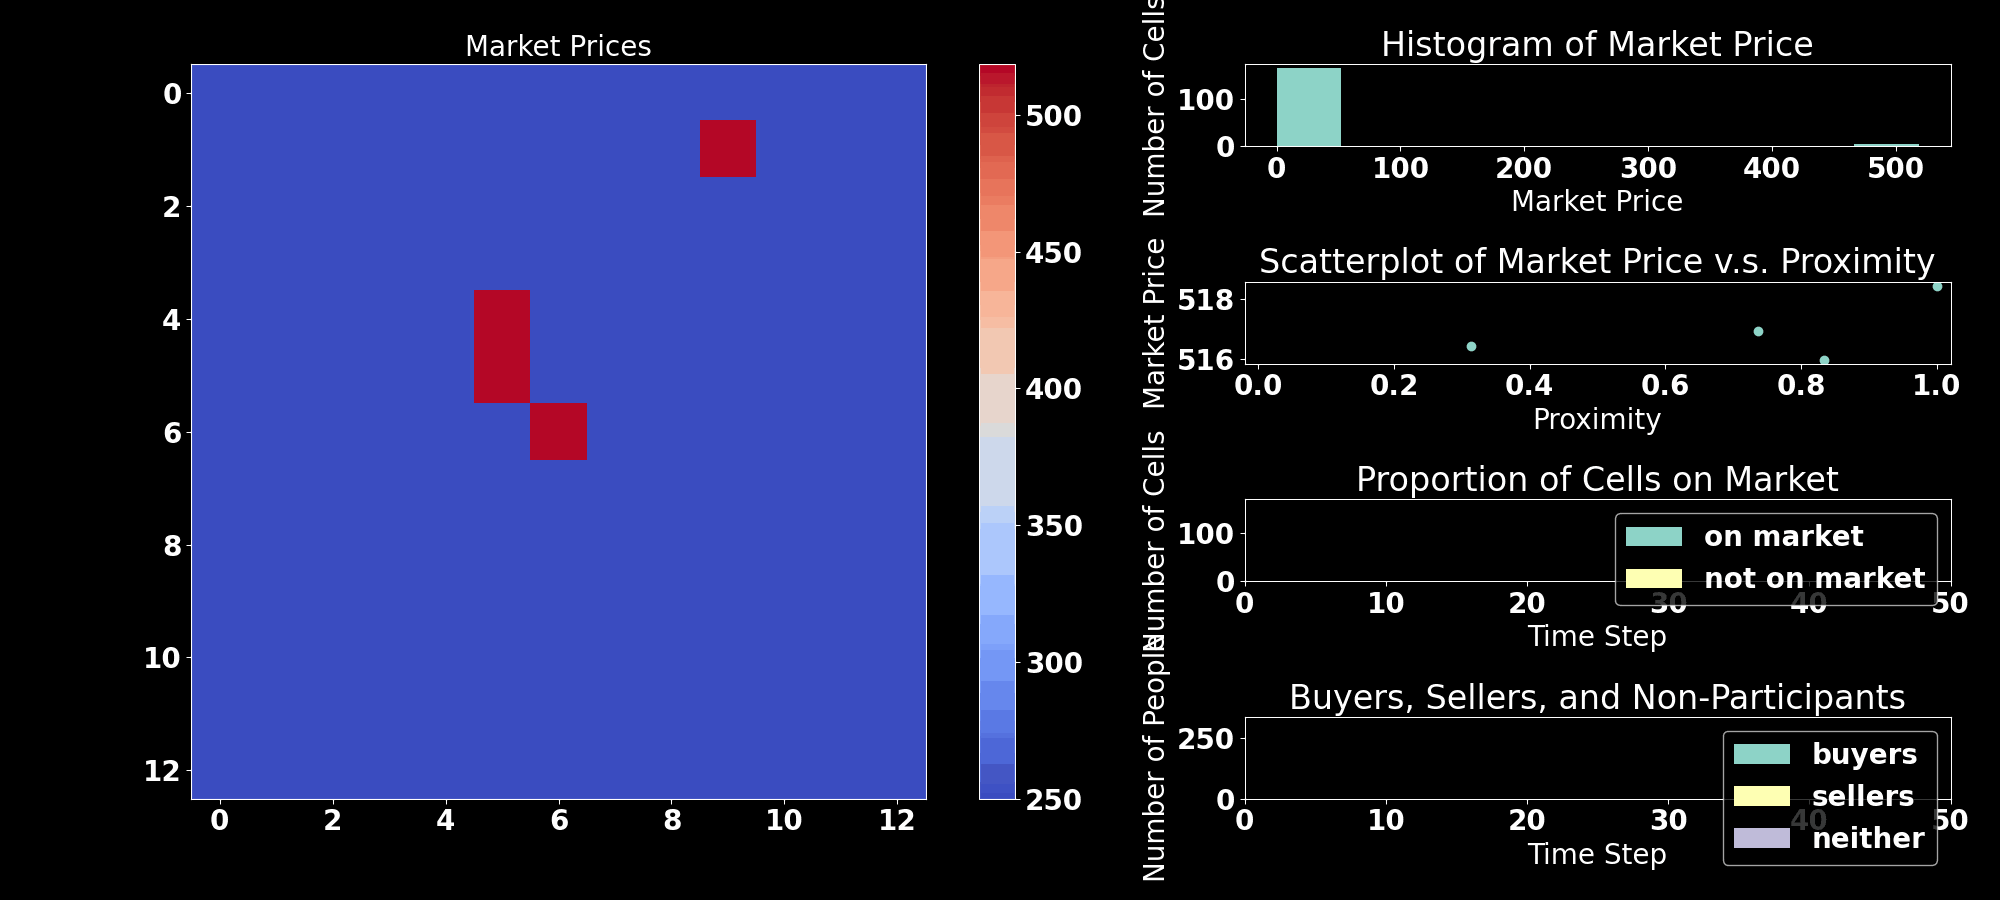

In [8]:
Image(filename=os.path.join(sim.output_directory, "movie.gif"))

## Analysis and Outputs

There are few metrics we can use to analyze and compare the outputs of our results. [Filatova, Parker, and van der Veen's paper discusses many metrics they looked at in Section 4: Simuation Experiments](http://jasss.soc.surrey.ac.uk/12/1/3.html).

## The Amenity of Cells in the Simulation

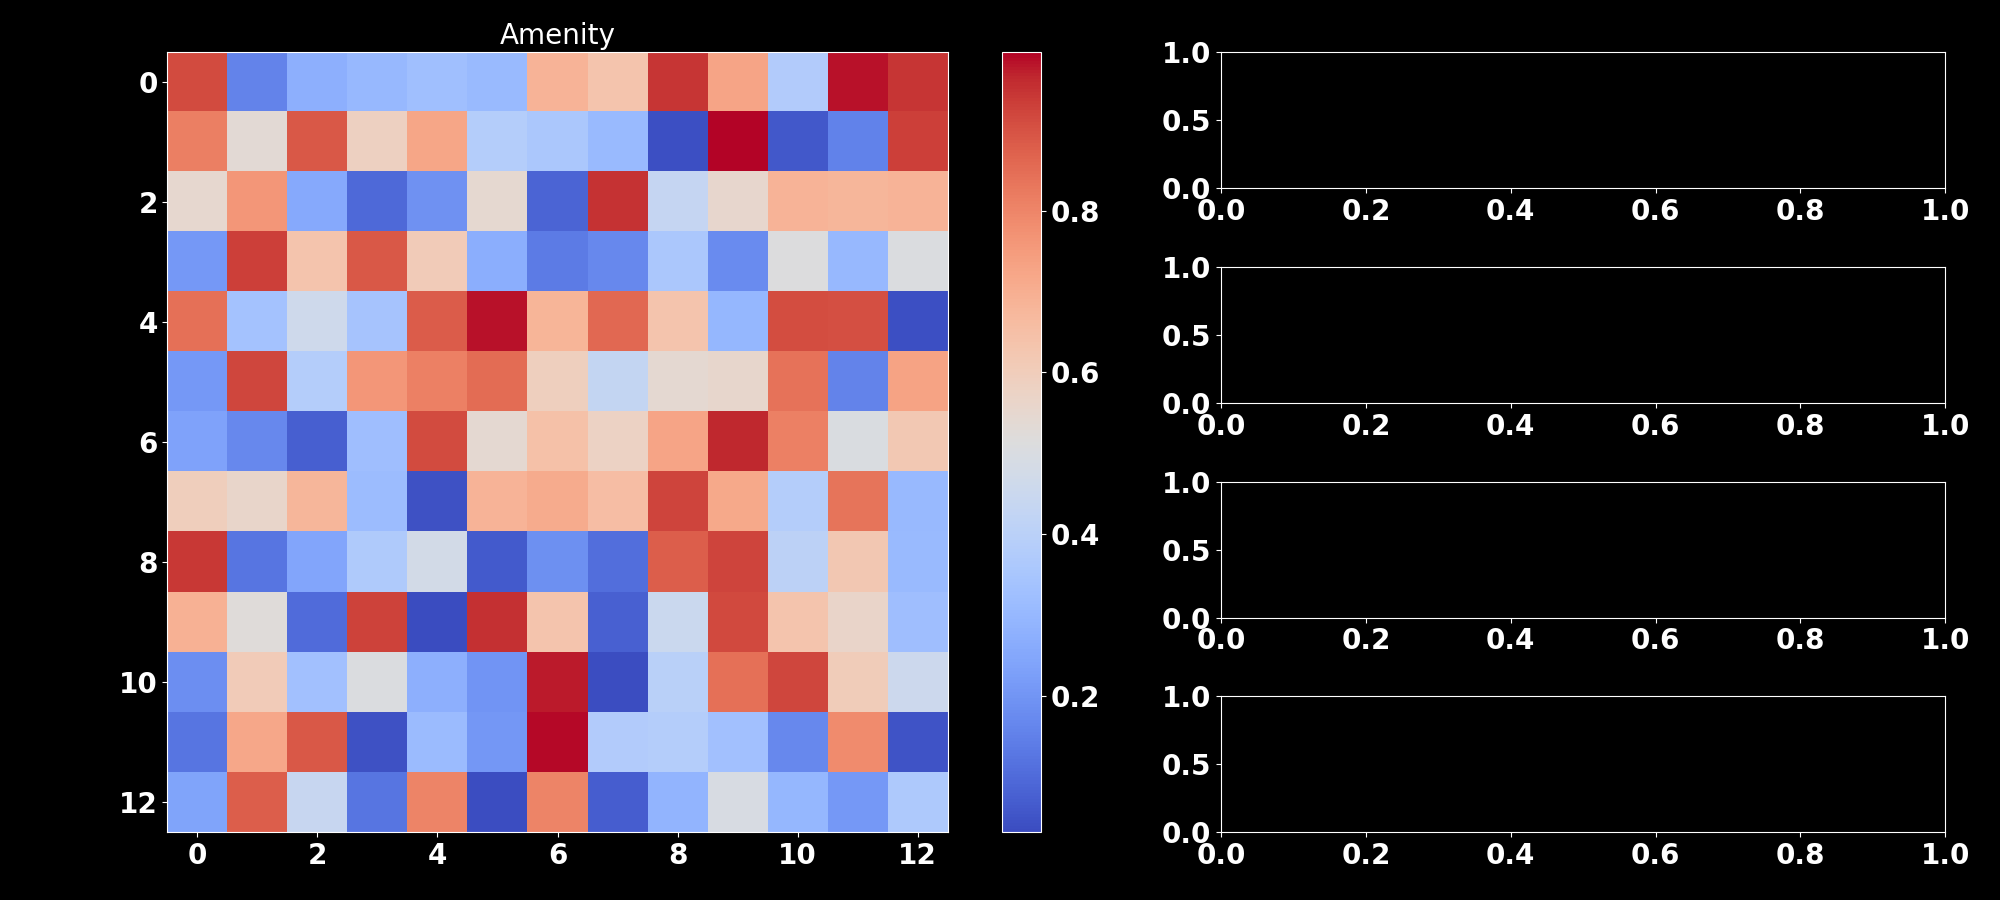

In [9]:
Image(filename=os.path.join(sim.output_directory, "Amenity-Cells.png"))

## The Proximity of Cells in the Simulation

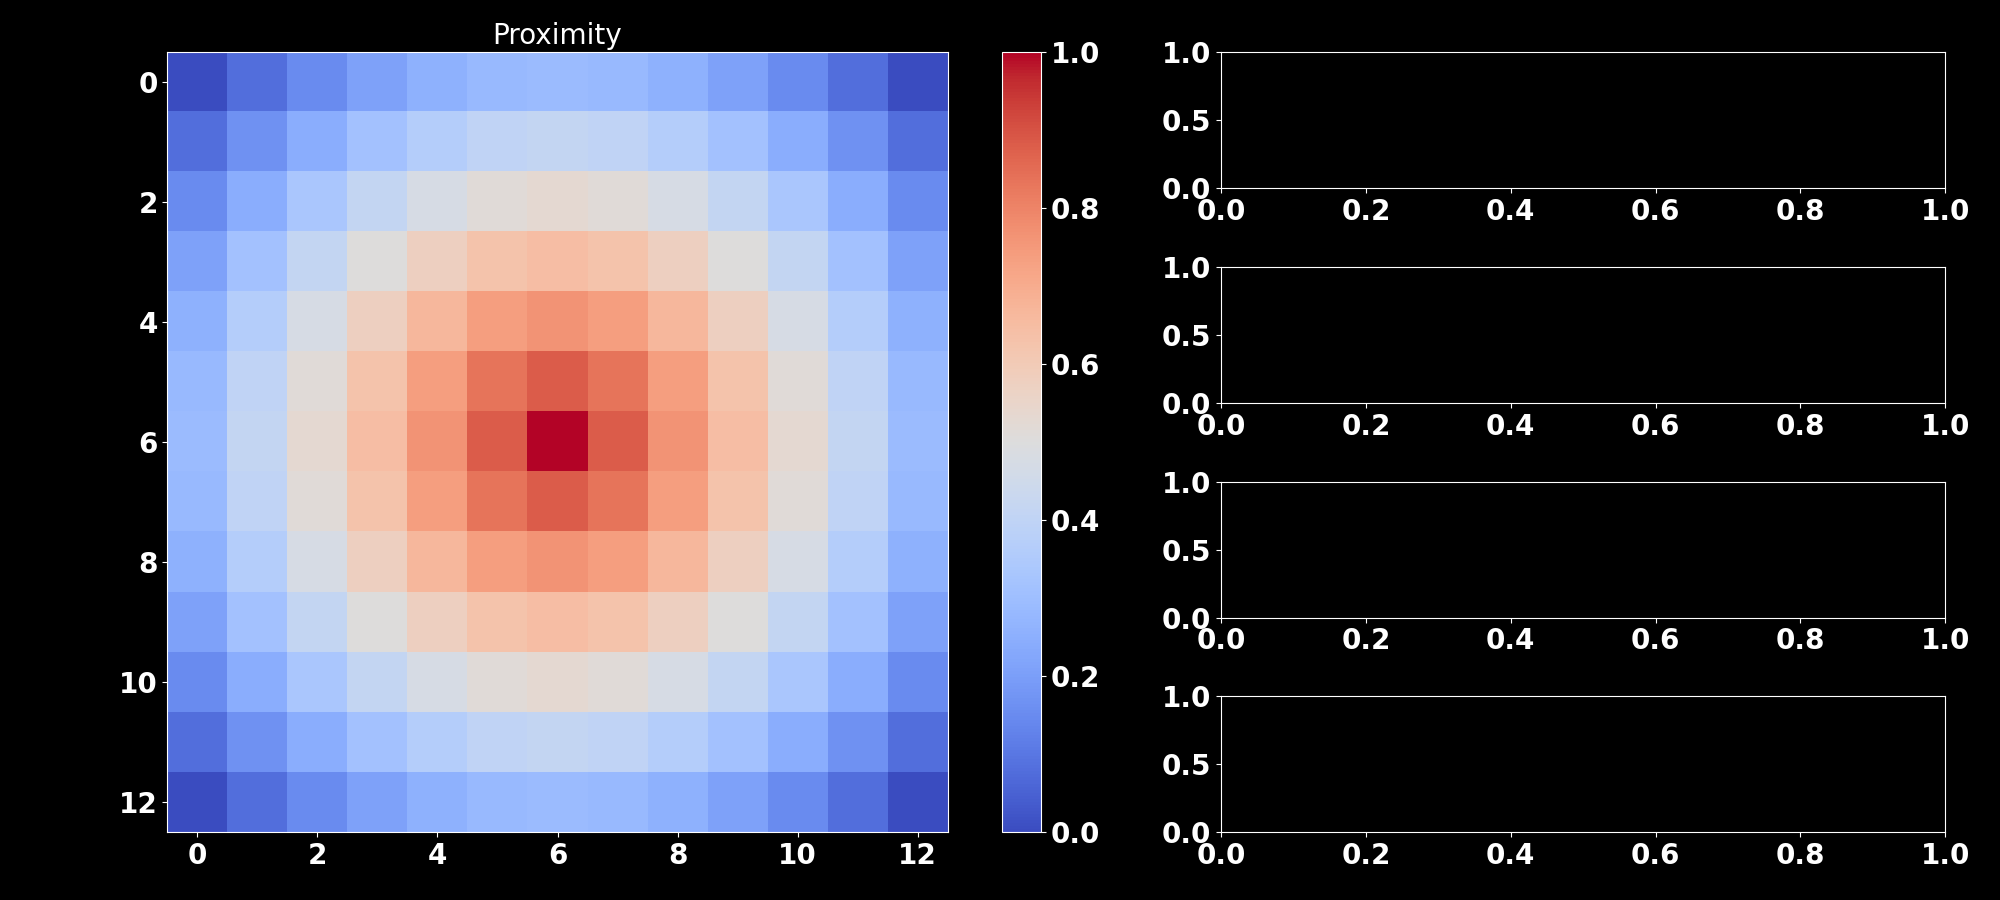

In [10]:
Image(filename=os.path.join(sim.output_directory, "Proximity-Cells.png"))

The attributes of the cells can be found in the output directory under "cells.csv"

In [11]:
cell_csv = pd.read_csv(os.path.join(sim.output_directory, "cells.csv"))
cell_csv.head()

Cell_ID  Location_X  Location_Y  Owner  Market_Price  On_Market   Amenity  \
0        0           0           0    205           0.0       True  0.910087   
1        1           0           1    269           0.0       True  0.158536   
2        2           0           2    181           0.0       True  0.273933   
3        3           0           3    270           0.0       True  0.299444   
4        4           0           4    322           0.0       True  0.326339   

   Proximity  
0   0.000000  
1   0.079553  
2   0.150163  
3   0.209431  
4   0.254644

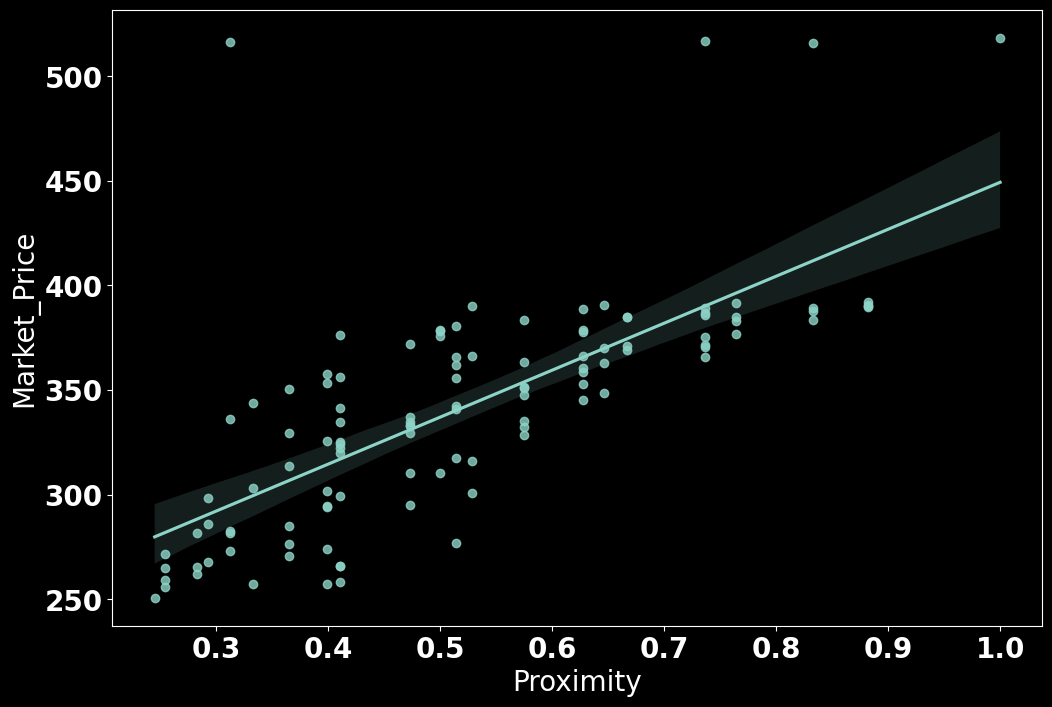

In [12]:
cell_csv=cell_csv[cell_csv["Market_Price"] > 0 ] # filter out unsold cells
sns.regplot(x=cell_csv["Proximity"], y=cell_csv["Market_Price"])
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.show()

The agent attributes are also in the output directory under "agents.csv"

**Note: Utility numbers in Filatova, Parker, and van der Veen seem to be reported as percentages rather than values (i.e. 65.48 vs. 0.6548). Keep this in mind when comparing metrics like individual utility and aggregate utility.**

In [13]:
agent_csv = pd.read_csv(os.path.join(sim.output_directory, "agents.csv"))
agent_csv.head()

Agent_ID  Affordability  Budget  Distance_Cost  Buying  Selling  \
0         0            0.7     800              1   False    False   
1         1            0.7     800              1   False    False   
2         2            0.7     800              1   False    False   
3         3            0.7     800              1   False    False   
4         4            0.7     800              1    True    False   

   Amenity_Preference  Proximity_Preference   Utility  
0            0.014578              0.282546  0.909080  
1            0.161564              0.412045  0.565390  
2            0.144006              0.468094  0.525270  
3            0.094117              0.453708  0.602457  
4            0.130431              0.627673 -1.000000

* The mean utility is 0.7692163760366838 and the standard deviation is 0.16244193892187878.
* The aggregate utility is 87.69066686818195 for 338 agents


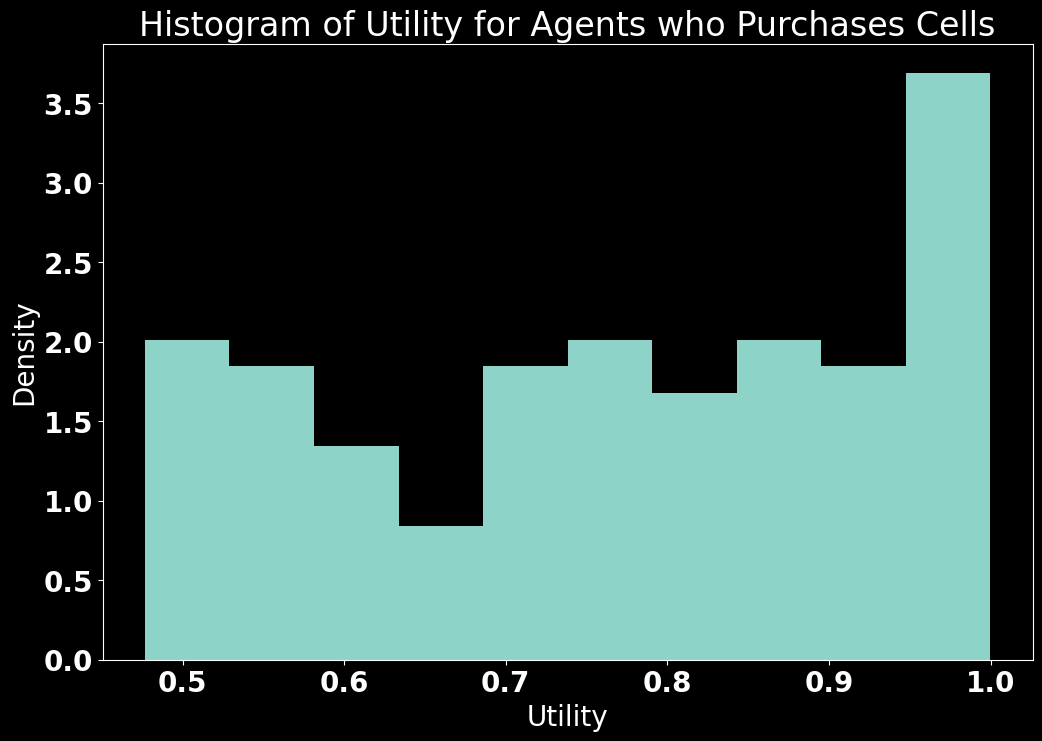

In [14]:
utilities = np.array([ u for u in agent_csv["Utility"] if u >= 0 ])
print("* The mean utility is {} and the standard deviation is {}.".format(np.mean(utilities), np.std(utilities)))
print("* The aggregate utility is {} for {} agents".format(np.sum(utilities),len(agent_csv)))
plt.hist(utilities, density=True)
plt.title("Histogram of Utility for Agents who Purchases Cells")
plt.xlabel("Utility")
plt.ylabel("Density")
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.show()

In [15]:
""" Cleaning up: deleting the outputs to reduce disk usage """
shutil.rmtree(sim.output_directory, ignore_errors=True)